# Star Trek Uniform Classifier - CNN

* Collect images of Star Trek uniforms
    * Red, Blue, Gold

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.layers import Conv2D # to add convolutional layers
from keras.layers import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
import os
from pathlib import Path
from PIL import Image

# Load data

In [17]:
# define data path and categories
data_dir = Path('rawData')
categories = ['commandRed', 'scienceBlue', 'operationGold']

In [20]:
# function to handle images
def clean_and_verify_data(base_path, folder_list):

    # iterate through categires
    for category in folder_list:
        path = base_path / category
        print(f"==== Checking for: {category} ====")

        files = list(path.glob('*'))
        for file_path in files:
            # remove everything except jpg, jpeg and png
            if file_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                print(f"Revoming: {file_path.name}")
                file_path.unlink()
                continue

            try:
                # try open img to check for corruption
                with Image.open(file_path) as img:
                    img.verify() # verify whether its img

                # convert to RBG in case more channels
                with Image.open(file_path) as img:
                    img = img.convert('RGB')
                    img = img.resize((128, 128)) # resize img 
                    img.save(file_path) # overwrite !!

            except (IOError, SyntaxError) as e:
                print(f"Deleting file: {file_path.name}")
                file_path.unlink()


In [21]:
clean_and_verify_data(data_dir, categories)

==== Checking for: commandRed ====
Revoming: download (13).svg
Revoming: imgi_403_831a5d31c83ad3e3b8981170c290e73ec09ce812_2000x2000.webp
Revoming: download (6).svg
Revoming: download (25).svg
Revoming: imgi_396_PBA-014817_1.webp
Revoming: download (24).svg
Revoming: download (7).svg
Revoming: download (12).svg
Revoming: imgi_448_250.webp
Revoming: download (28).svg
Revoming: download (23).svg
Revoming: download (19).svg
Revoming: download (15).svg
Revoming: download.svg
Revoming: download (14).svg
Revoming: download (18).svg
Revoming: imgi_377_mspin_googcolor_medium.svg
Revoming: download (22).svg
Revoming: download (1).svg
Revoming: imgi_443_460980-large_default.webp
Revoming: imgi_12_24px.svg
Revoming: download (21).svg
Revoming: download (2).svg
Revoming: download (17).svg
Revoming: download (16).svg
Revoming: imgi_427_Y1r0mxAiRNy_Z5TGfDtfCw.webp
Revoming: imgi_389_TEk83bOoRkee4-wR3cgp2A.webp
Revoming: imgi_421_Next-Generation-Star-Trek-Picard-Suede-Leather-Jacket.webp
Revoming: do

# Normalize data and split

In [36]:
from keras import layers
# constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# load and split
train_ds = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2, # 20% for testing
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2, # 20% for validation
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# save classes name for debug
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# normalize
normalization_layer = layers.Rescaling(1./255)

# apply to dataset
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 1084 files belonging to 3 classes.
Using 868 files for training.
Found 1084 files belonging to 3 classes.
Using 216 files for validation.
Classes found: ['commandRed', 'operationGold', 'scienceBlue']


# Veryfing if data is GOOD

## Visual verification

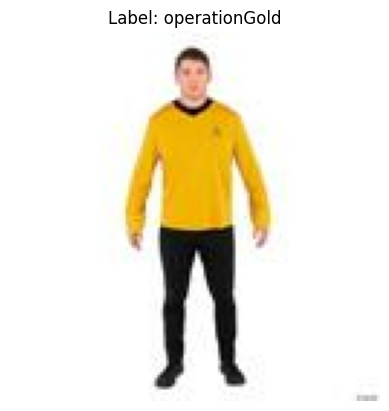

Max pixel value: 1.0
Min pixel value: 0.0


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# take one batch from ds
for images, labels in train_ds.take(1):
    # images is a tensor of shape (32, 128, 128, 3)
    # labels is a tensor of shape (32, 3)
    
    first_image = images[0].numpy()
    first_label = labels[0].numpy()
    
    plt.imshow(first_image)
    plt.title(f"Label: {class_names[np.argmax(first_label)]}")
    plt.axis('off')
    plt.show()

    # print pixel range (max should be 1 and min should be 0)
    print(f"Max pixel value: {np.max(first_image)}")
    print(f"Min pixel value: {np.min(first_image)}")

## Shape verification

In [ ]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}") # expect (32, 128, 128, 3), batch size, height, widht, channel numb RGB
    print(f"Label batch shape: {labels.shape}") # expect (32, 3)
    break

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 3)


## Class balance verification - after cleaning

In [ ]:
for category in class_names:
    path = f'rawData/{category}'
    print(f"{category}: {len(os.listdir(path))} images")

commandRed: 410 images
operationGold: 278 images
scienceBlue: 396 images


* operationGold is a bit smaller. **NEED TO AUGMENTATION** 

## Normalization check

In [41]:
for images, labels in train_ds.take(1):
    print(f"Data type: {images.dtype}") 
    print(f"First pixel value: {images[0, 0, 0, 0].numpy()}")
# expect float32

Data type: <dtype: 'float32'>
First pixel value: 0.24313727021217346


2026-02-06 16:23:59.453581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Building Convolutional Neural Network

In [46]:
# building the model

# augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def star_trek_cnn_model():
    '''
    input
    3 Conv2D / Maxpooling layers; relu
    flatten
    dense; relu
    regularization
    output, dense; softmax to probabilities
    '''
    model = keras.Sequential([
        # input
        layers.Input(shape=(128, 128, 3)),

        # data aug
        data_augmentation,

        # first layer, edges
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # second layer, shapes
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # third layer, complex patterns
        layers.Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),

        # output layer
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
# init and run model
model = star_trek_cnn_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training Model

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=1
)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5576 - loss: 0.9809 - val_accuracy: 0.6528 - val_loss: 0.8505
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6843 - loss: 0.7964 - val_accuracy: 0.7546 - val_loss: 0.7156
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7189 - loss: 0.7340 - val_accuracy: 0.7222 - val_loss: 0.7187
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7247 - loss: 0.6995 - val_accuracy: 0.7083 - val_loss: 0.7164
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.7247 - loss: 0.6627 - val_accuracy: 0.6759 - val_loss: 0.6726
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.7408 - loss: 0.6450 - val_accuracy: 0.7037 - val_loss: 0.6996
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.7396 - loss: 0.5989 - val_accuracy: 0.7130 - val_loss: 0.6636
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.7396 - loss: 0.5731 - val_accuracy: 0.754

In [49]:
scores = model.evaluate(val_ds, verbose=0)
print(f"Test Accuracy: {scores[1]:.4f}")
print(f"Test Loss: {scores[0]:.4f}")

Test Accuracy: 0.7315
Test Loss: 0.6575
